## Fin-bert/Bert/Vader Model Evaluation

In [2]:
import pandas as pd
import numpy as np
import ast
import re
import torch
import gc
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datetime import datetime
from collections import Counter
from tqdm import tqdm

In [4]:
# Split tweets into financial and non-financial

def classify_financial_text(text):
    """
    Determine if text contains financial terms
    
    Args:
        text (str): Input text
        
    Returns:
        bool: If text contains financial terms, return True, otherwise return False
    """
    try:
        # Predefined financial terms regex
        financial_pattern = r'\b(?:\$[A-Z]{1,5}\b|stock(?:\s*price|s?)|price\s*target|market\s*(?:cap|value)|' \
                          r'shares|share\s*price|earnings(?:\s*report|per\s*share|call)|semiconductor|chip\s*industry|' \
                          r'invest(?:ing|ment)|trading|portfolio|dividend|buyback|' \
                          r'\b(?:bull|bear)(?:ish|market)\b|valuation|P/E|price-to-earnings|' \
                          r'analyst\s*rating|upgrade|downgrade|(?:financial|quarterly)\s*results|' \
                          r'volume|liquidity|SEC\s*filing|10-[KQ]|IPO|FPO|secondary\s*offering)'
        
        # Convert input to string and check if it contains financial terms
        return bool(re.search(financial_pattern, str(text), flags=re.IGNORECASE))
    except Exception as e:
        print(f"Error in classify_financial_text: {str(e)}")
        return False

In [5]:
def main():
    print("Loading cleaned tweet data...")
    df = pd.read_csv("../2_data/cleaned_nvda.csv")

    if 'Cleaned_Tweet' not in df.columns:
        print("Error: Missing 'Cleaned_Tweet' column in the data.")
        return

    print("Classifying tweets as financial or non-financial...")
    tqdm.pandas(desc="Classifying")
    df['is_financial'] = df['Cleaned_Tweet'].progress_apply(classify_financial_text)

    print("Saving new file with financial classification...")
    output_path = "../2_data/cleaned_nvda_with_financial_flag.csv"
    df.to_csv(output_path, index=False)

    print(f"Done. File saved to: {output_path}")


if __name__ == "__main__":
    main()

Loading cleaned tweet data...
Classifying tweets as financial or non-financial...


Classifying: 100%|██████████| 501908/501908 [00:02<00:00, 219042.29it/s]


Saving new file with financial classification...
Done. File saved to: ../2_data/cleaned_nvda_with_financial_flag.csv


In [6]:
import pandas as pd

# Load the file that contains the 'is_financial' column
df = pd.read_csv("../2_data/cleaned_nvda_with_financial_flag.csv")

# Check if the 'is_financial' column exists
if 'is_financial' not in df.columns:
    print("Error: 'is_financial' column not found.")
else:
    total = len(df)  # Total number of tweets
    financial = df['is_financial'].sum()  # Number of financial tweets (is_financial == 1)
    proportion = financial / total  # Proportion of financial tweets

    print(f"Total number of tweets: {total}")
    print(f"Number of financial tweets: {financial}")
    print(f"Proportion of financial tweets: {proportion:.2%}")

Total number of tweets: 501908
Number of financial tweets: 65921
Proportion of financial tweets: 13.13%


In [7]:
import pandas as pd

# Load original CSV
df = pd.read_csv("../2_data/cleaned_nvda_with_financial_flag.csv")

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Filter for years 2017–2022
df = df[df['created_at'].dt.year.between(2017, 2022)]

# Ensure is_financial is actually boolean
df = df[df['is_financial'].isin([True, False])]

# Count available samples
n_fin_available = df[df['is_financial'] == True].shape[0]
n_nonfin_available = df[df['is_financial'] == False].shape[0]

# Define required numbers
n_fin_required = 40
n_nonfin_required = 260

# Adjust if not enough data
if n_fin_available < n_fin_required:
    print(f"⚠️ Only {n_fin_available} financial tweets available (needed {n_fin_required})")
    n_fin_required = n_fin_available

if n_nonfin_available < n_nonfin_required:
    print(f"⚠️ Only {n_nonfin_available} non-financial tweets available (needed {n_nonfin_required})")
    n_nonfin_required = n_nonfin_available

# Safe sampling
df_fin = df[df['is_financial'] == True].sample(n=n_fin_required, random_state=42)
df_nonfin = df[df['is_financial'] == False].sample(n=n_nonfin_required, random_state=42)

# Combine and shuffle
df_sampled = pd.concat([df_fin, df_nonfin]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
output_path = "../2_data/sample_300_for_manual.csv"
df_sampled.to_csv(output_path, index=False)

# Print summary
print("✅ Sampling complete.")
print(f"Saved to: {output_path}")
print("Final sample size:", len(df_sampled))
print("Financial counts:\n", df_sampled['is_financial'].value_counts())

✅ Sampling complete.
Saved to: ../2_data/sample_300_for_manual.csv
Final sample size: 300
Financial counts:
 is_financial
False    260
True      40
Name: count, dtype: int64


In [8]:
import pandas as pd
from tqdm import tqdm
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# === Load data ===
df = pd.read_csv("../2_data/sample_300_for_manual.csv")
text_column = "Processed_Tweet" if "Processed_Tweet" in df.columns else df.columns[-1]

# === Define model list (model name : output column) ===
model_list = {
    # Financial models (FinBERT)
    "yiyanghkust/finbert-tone": "label_fin_finbert-tone",
    "ProsusAI/finbert": "label_fin_finbert",

    # Non-financial models (BERT variants)
    "cardiffnlp/twitter-roberta-base-sentiment": "label_nonfin_roberta",
    "finiteautomata/bertweet-base-sentiment-analysis": "label_nonfin_bertweet"
}

# === Load transformer models ===
print("Loading transformer models...")
transformer_pipelines = {
    model_name: pipeline("sentiment-analysis", model=model_name, truncation=True, max_length=512)
    for model_name in model_list
}

# === Load VADER ===
vader = SentimentIntensityAnalyzer()

# === Initialize result columns ===
for col_name in model_list.values():
    df[col_name] = ""
# df["score_nonfin_vader"] = 0.0

# === Scoring ===
print("Scoring tweets...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row[text_column])[:512]

    if row['is_financial'] == True:
        for model_name, col in model_list.items():
            if col.startswith("label_fin"):
                result = transformer_pipelines[model_name](text)[0]
                df.at[idx, col] = result['label']
    else:
        for model_name, col in model_list.items():
            if col.startswith("label_nonfin"):
                result = transformer_pipelines[model_name](text)[0]
                df.at[idx, col] = result['label']
        df.at[idx, "score_nonfin_vader"] = vader.polarity_scores(text)["compound"]

# === Save result ===
output_path = "../2_data/515sample_300_with_model_labels.csv"
df.to_csv(output_path, index=False)
print(f"✅ Done. File saved to: {output_path}")

ModuleNotFoundError: No module named 'vaderSentiment'

In [9]:
import pandas as pd

# Load the annotated result file
df = pd.read_csv("../2_data/515sample_300_with_model_labels.csv")

# Label columns
label_cols = [col for col in df.columns if col.startswith("label_")]

# Label mapping function
def standardize_label(label):
    if not isinstance(label, str):
        return ""
    label = label.strip().lower()
    if label in ["label_2", "pos", "positive"]:
        return "positive"
    elif label in ["label_1", "neu", "neutral"]:
        return "neutral"
    elif label in ["label_0", "neg", "negative"]:
        return "negative"
    else:
        return ""

# Apply mapping
for col in label_cols:
    df[col] = df[col].apply(standardize_label)

# Optional: Create vader label column
if "score_nonfin_vader" in df.columns:
    def vader_to_label(score):
        if pd.isna(score):
            return ""
        elif score >= 0.05:
            return "positive"
        elif score <= -0.05:
            return "negative"
        else:
            return "neutral"
    df["label_nonfin_vader"] = df["score_nonfin_vader"].apply(vader_to_label)

# Save standardized file
output_path = "../2_data/sample_300_labels_standardized.csv"
df.to_csv(output_path, index=False)
print(f"✅ Saved standardized labels to: {output_path}")

✅ Saved standardized labels to: ../2_data/sample_300_labels_standardized.csv


✅ Evaluation Summary:
                    Model  Accuracy  Precision  Recall  F1 Score
0  label_fin_finbert-tone    0.6250     0.7321  0.5516    0.5634
1       label_fin_finbert    0.4250     0.1532  0.2982    0.2024
2    label_nonfin_roberta    0.6192     0.3338  0.3275    0.3236
3   label_nonfin_bertweet    0.6077     0.3743  0.3562    0.3593
4      label_nonfin_vader    0.5423     0.4243  0.4568    0.4145


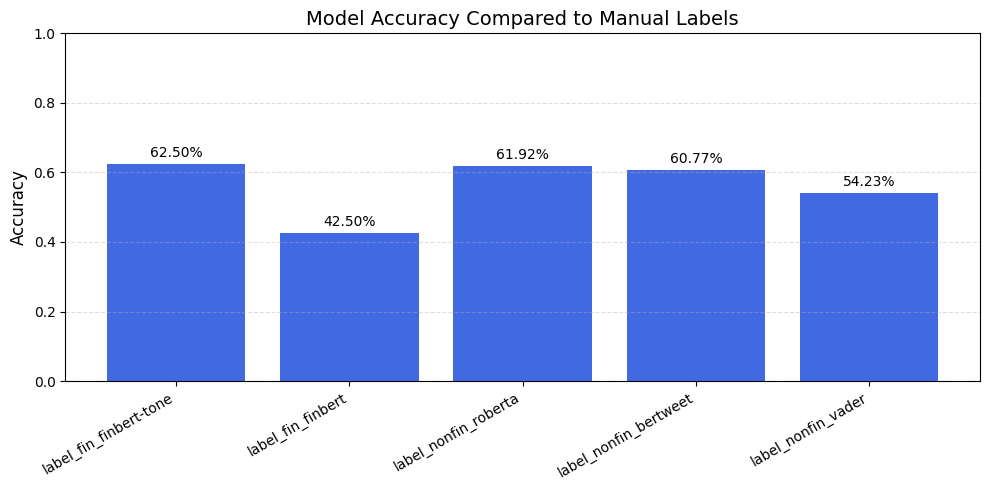

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# === Step 1: Load the labeled data ===
df = pd.read_csv("../2_data/sample_300_labels_standardized_mannualscore.csv")

# === Step 2: Define model columns ===
true_labels = df["mannual_sentiment_label"]

# Financial sentiment models
finbert_models = ["label_fin_finbert-tone", "label_fin_finbert"]

# Non-financial sentiment models
nonfin_models = ["label_nonfin_roberta", "label_nonfin_bertweet", "label_nonfin_vader"]

all_models = finbert_models + nonfin_models

# === Step 3: Evaluate all models ===
metrics_summary = []

for model in all_models:
    valid = df[model].notna()
    y_true = true_labels[valid]
    y_pred = df[model][valid]

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 (macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=["positive", "neutral", "negative"], average="macro", zero_division=0
    )

    metrics_summary.append({
        "Model": model,
        "Accuracy": round(acc, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    })

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_summary)

# === Step 4: Print summary ===
print("✅ Evaluation Summary:")
print(metrics_df)

# === Step 5: Plot Accuracy Bar Chart ===
plt.figure(figsize=(10, 5))
plt.bar(metrics_df["Model"], metrics_df["Accuracy"], color='royalblue')
plt.title("Model Accuracy Compared to Manual Labels", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1)
for i, val in enumerate(metrics_df["Accuracy"]):
    plt.text(i, val + 0.02, f"{val:.2%}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()